In [272]:
from datasets import load_dataset
import random
from transformers import AutoTokenizer, AutoModel, GPT2LMHeadModel, GPT2Tokenizer
import torch
from tqdm import tqdm
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import re
import matplotlib.pyplot as plt

In [196]:
bert_model_name = "dkleczek/bert-base-polish-cased-v1"
bert_tokenizer = AutoTokenizer.from_pretrained(bert_model_name)
bert_model = AutoModel.from_pretrained(bert_model_name, output_hidden_states=True)
bert_model.eval()

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(60000, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [198]:
gpt2_model_name = "sdadas/polish-gpt2-medium"
gpt2_tokenizer = AutoTokenizer.from_pretrained(gpt2_model_name)
gpt2_model = AutoModel.from_pretrained(gpt2_model_name, output_hidden_states=True)
gpt2_model.eval()

GPT2Model(
  (wte): Embedding(51200, 1024)
  (wpe): Embedding(2048, 1024)
  (drop): Dropout(p=0.1, inplace=False)
  (h): ModuleList(
    (0-23): 24 x GPT2Block(
      (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (attn): GPT2SdpaAttention(
        (c_attn): Conv1D(nf=3072, nx=1024)
        (c_proj): Conv1D(nf=1024, nx=1024)
        (attn_dropout): Dropout(p=0.1, inplace=False)
        (resid_dropout): Dropout(p=0.1, inplace=False)
      )
      (ln_2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (mlp): GPT2MLP(
        (c_fc): Conv1D(nf=4096, nx=1024)
        (c_proj): Conv1D(nf=1024, nx=4096)
        (act): FastGELUActivation()
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (ln_f): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
)

In [2]:
dataset = load_dataset("clarin-knext/wsd_polish_datasets", trust_remote_code=True)

1. Wczytaj zbiór danych i wybierz z niego teksty z lematami
2. Mapowanie słów na zdania i odrzucenie słów nie występujących co najmniej 5 razy
3. wylosowanie n słów w kontekście
4. Sprawdzenie embeddingów wylosowanych słów ze względu na warstwę i policzenie podobieństwa
5. Utworzenie wykresu
6. 

In [34]:
def split_text_into_sentences_with_indices(text):
    pattern = re.compile(r'(?<!\w\.\w.)(?<![A-Z][a-z]\.)(?<=\.|\?|\!)\s')
    
    sentences = []
    start = 0
    
    for match in pattern.finditer(text):
        end = match.end()
        sentence = text[start:end].strip()
        sentences.append((sentence, start, end - 1))
        start = end

    if start < len(text):
        sentences.append((text[start:].strip(), start, len(text) - 1))

    return sentences

In [ ]:
# sentences = {}
# words = {}

# for i, sample in enumerate(dataset['train']):
#     sentences[i] = {'text': sample['text'], 'lemma': sample['tokens']['lemma']}
#     for j, (lemma, pos) in enumerate(zip(sample['tokens']['lemma'], sample['tokens']['pos'])):
#         if pos == 'interp':
#             continue
#         if lemma not in words:
#             words[lemma] = []
#         words[lemma].append((i, j))

In [ ]:
sentences = {}
words = {}

i = 0
for sample in dataset['train']:
    split_sentences = split_text_into_sentences_with_indices(sample['text'])
    prev_j = 0
    for sentence, start_idx, end_idx in split_sentences:
        for j in range(prev_j, len(sample['tokens']['position'])):
            if sample['tokens']['position'][j][1] == end_idx:
                if len(sentence) <= 512:
                    sentences[i] = {'text': sentence, 'lemma': sample['tokens']['lemma'][prev_j : j + 1], 'orth': sample['tokens']['orth'][prev_j : j + 1]}
                    
                    for k, (lemma, pos) in enumerate(zip(sample['tokens']['lemma'][prev_j : j + 1], sample['tokens']['pos'][prev_j : j + 1])):
                        if pos == 'interp':
                            continue
                        if lemma not in words:
                            words[lemma] = []
                        words[lemma].append((i, k))

                prev_j = j + 1
                i += 1
                break

 14%|█▍        | 14/100 [2:20:31<14:23:13, 602.25s/it]


# Badanie anizotropii

In [266]:
words_to_check = random.sample(list(words.values()), 100)
words_to_check = [random.choice(word) for word in words_to_check]

In [ ]:
# def get_word_in_sentence_emeddings(sentence_i, word_i):
#     text = sentences[sentence_i]['text']
#     with torch.no_grad():
#         inputs = tokenizer(text, return_tensors='pt', add_special_tokens=False, truncation=True, max_length=512, padding="max_length")
#         input_ids = inputs["input_ids"]
#         attention_mask = inputs['attention_mask']
#         outputs = model(input_ids, attention_mask=attention_mask)
#     hidden_states = outputs.hidden_states
#     tokens_ids = tokenizer.convert_ids_to_tokens(input_ids[0])
#     # print(tokens_ids[word_i], sentences[sentence_i]['lemma'][word_i])
#     word_embeddings = [layer_output[0, word_i].numpy() for layer_output in hidden_states]
#     word_embeddings = [model.embeddings.word_embeddings(input_ids)[0, word_i], *word_embeddings]
#     print(word_embeddings[-1].shape)
#     return word_embeddings

In [ ]:
def get_bert_word_embedding(tokens_text, token_embeddings, word):
    subtoken_ids = []
    prev_text = ''
    for i, token in enumerate(tokens_text):
        if token.startswith("##"):
            prev_text += token[2:]
            subtoken_ids.append(i)
        else:
            subtoken_ids = [i]
            prev_text = token

        if prev_text == word:
            return torch.mean(token_embeddings[subtoken_ids], dim=0)
        
    return None

In [ ]:
def get_gpt2_word_embedding(tokens_text, token_embeddings, word):
    subtoken_ids = []
    word2 = re.sub(r'[^a-zA-Z0-9]', '', word)
    prev_text = ''
    for i, token in enumerate(tokens_text):

        if prev_text == word2:
            return torch.mean(token_embeddings[subtoken_ids], dim=0)

        new_fragment = re.sub(r'[^a-zA-Z0-9]', '', token)
        if new_fragment:
            if token.startswith("Ġ"):
                prev_text = new_fragment
                subtoken_ids = [i]
            else:
                subtoken_ids.append(i)
                prev_text += new_fragment
        else:
            prev_text = ''
            subtoken_ids = []

    if prev_text == word2:
        return torch.mean(token_embeddings[subtoken_ids], dim=0)

    return None

In [ ]:
def get_word_in_sentence_embeddings(sentence_i, word_i, model):
    text = sentences[sentence_i]['text']
    word = sentences[sentence_i]['orth'][word_i]
    
    if model == 'bert':
        tokens = bert_tokenizer(text, return_tensors='pt')
        input_ids = tokens['input_ids'].squeeze()
        tokens_text = bert_tokenizer.convert_ids_to_tokens(input_ids)
        with torch.no_grad():
            outputs = bert_model(**tokens, output_hidden_states=True)
    
    elif model == 'gpt2':
        tokens = gpt2_tokenizer(text, return_tensors='pt')
        input_ids = tokens['input_ids'].squeeze()
        tokens_text = gpt2_tokenizer.convert_ids_to_tokens(input_ids)
        with torch.no_grad():
            outputs = gpt2_model(**tokens, output_hidden_states=True)

    hidden_states = outputs.hidden_states

    all_layers_embeddings = []

    for layer_embeddings in hidden_states:
        token_embeddings = layer_embeddings.squeeze()
        if model == 'bert':
            word_embedding = get_bert_word_embedding(tokens_text, token_embeddings, word)
        elif model == 'gpt2':
            word_embedding = get_gpt2_word_embedding(tokens_text, token_embeddings, word)
        if word_embedding:
            all_layers_embeddings.append(word_embedding)

    return all_layers_embeddings


In [218]:
def calculate_avg_sim(words_to_check, model):
    word_embeddings = [get_word_in_sentence_embeddings(*instance, model) for instance in tqdm(words_to_check)]
    layers_embeddings = [[torch.Tensor(embeddings[i]).detach().numpy() for embeddings in word_embeddings] for i in range(len(word_embeddings[0]))]

    layers_sim = []
    for layer_embeddings in layers_embeddings:
        similarity_matrix = cosine_similarity(layer_embeddings)
        n = similarity_matrix.shape[0]
        mask = np.ones((n, n)) - np.eye(n)

        sim_no_diag = similarity_matrix * mask
        sum_sim = np.sum(sim_no_diag)
        layers_sim.append(sum_sim / (n * (n - 1)))

    return layers_sim

In [219]:
bert_layers_sim = calculate_avg_sim(words_to_check, 'bert')

100%|██████████| 100/100 [00:04<00:00, 23.74it/s]


In [267]:
gpt2_layers_sim = calculate_avg_sim(words_to_check, 'gpt2')






































































































100%|██████████| 100/100 [00:16<00:00,  5.95it/s]


In [268]:
bert_layers_sim

[0.1242108559755919,
 0.1561747564046145,
 0.18470765863549943,
 0.22061720420032588,
 0.2540712910668567,
 0.2525462965851631,
 0.2364299280977234,
 0.21732487765902822,
 0.2327784518167527,
 0.26443587575446476,
 0.2749206278691388,
 0.28072974514931137,
 0.20673513979077188]

In [271]:
gpt2_layers_sim

[0.1384280436892754,
 0.7174877753763488,
 0.7247057381708815,
 0.6822423840351779,
 0.6330162386165349,
 0.59317576838709,
 0.5724568023645046,
 0.5527765642571019,
 0.5365147434390442,
 0.5228179862344111,
 0.5152724108558543,
 0.5142191308955991,
 0.5179921030366059,
 0.5236430239190131,
 0.5271788560809813,
 0.5290474708242849,
 0.5238527476505348,
 0.5265272594540559,
 0.5359213618849489,
 0.5432974416232019,
 0.5628778416693512,
 0.592616684938019,
 0.636370044045075,
 0.6831254293641659,
 0.26388407760798327]

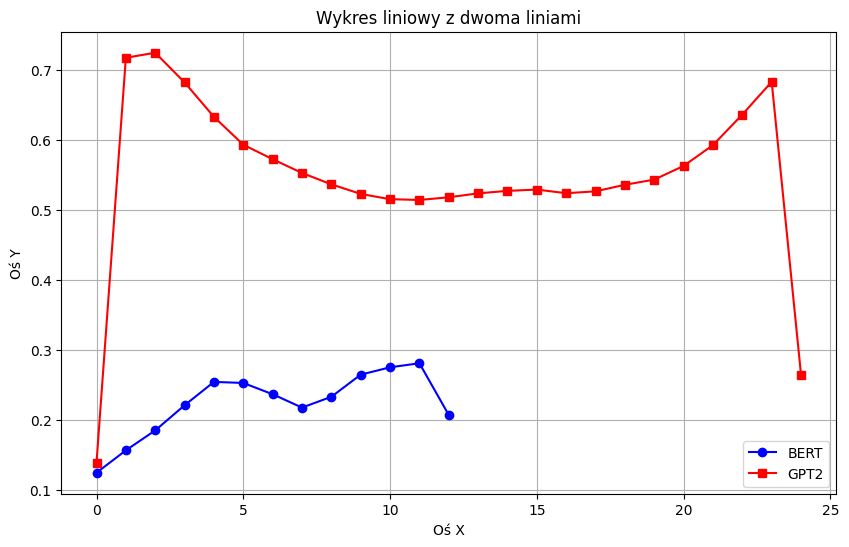

In [ ]:
plt.figure(figsize=(10, 6))

# Dodawanie pierwszej linii
plt.plot(range(len(bert_layers_sim)), bert_layers_sim, label='BERT', color='blue', marker='o')

# Dodawanie drugiej linii
plt.plot(range(len(gpt2_layers_sim)), gpt2_layers_sim, label='GPT2', color='red', marker='s')

# Dodawanie tytułu i etykiet osi
plt.title('Średnie podobieństwo dla losowo wybranych słów')
plt.xlabel('Oś X')
plt.ylabel('Oś Y')

# Dodawanie legendy
plt.legend()

# Wyświetlanie wykresu
plt.grid(True)
plt.show()